# Statistical analysis between coastal and adjacent ocean cells around Australia

## Importing packages

In [1]:
from datetime import date 
from datetime import datetime
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
import scipy.ndimage as ndimage
from scipy.ndimage import convolve
from scipy.ndimage.measurements import label, find_objects
import xarray as xr

## Opening the mask file

In [2]:
# aus_coast_grids_new created using the ERA5-Land land-sea mask

new_coastal = xr.open_dataset('/g/data/e14/cp3790/Charuni/Tasmania/aus_coast_grids_new.nc')
nc = new_coastal.lsm

In [3]:
times = pd.date_range("1982/01/01", "2019/01/01",freq='D',closed='left')
time_da = xr.DataArray(times, [('time', times)])
time_da

<xarray.DataArray (time: 13514)>
array(['1982-01-01T00:00:00.000000000', '1982-01-02T00:00:00.000000000',
       '1982-01-03T00:00:00.000000000', ..., '2018-12-29T00:00:00.000000000',
       '2018-12-30T00:00:00.000000000', '2018-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 2018-12-31

In [4]:
# adding a time dimension spanning from 1982-01-01 to 2018-12-31 as I have values within this date range in my land and ocean datasets

new_coastal_x = nc.expand_dims(time=time_da)

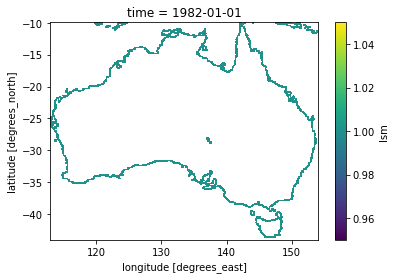

In [5]:
new_coastal_x.isel(time=0).plot()

In [6]:
# this stacks all lat, lon pairs corresponding to the coastal cells 

coast_sel_stacked = new_coastal_x.stack(latlon=('latitude', 'longitude')).dropna(dim='latlon')

## Severity datasets

In [7]:
# thw severity 
thw = xr.open_dataset('/g/data/e14/cp3790/Charuni/NCI/ERA5-T2M/thw-events-new.nc').sel(time=slice('1982', '2018'), longitude=slice(113.0, 154.0), latitude=slice(-10.0, -44.0))
anom = thw['severity']

In [8]:
# mhw severity 
files = sorted(glob.glob('/g/data/e14/cp3790/Charuni/MHW-updated/mhw_severity.pc90.*.nc'))
mhw = xr.open_mfdataset(files, combine='by_coords').sel(time=slice('1982', '2018'), lon=slice(113.0, 154.0), lat=slice(-44.0, -10.0))

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/xarray/coding/times.py:113: SerializationWarning: Ambiguous reference date string: 01-01-01 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-01-01 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


In [9]:
sev = mhw.severity

Using the stacked latlon locations of coastal cells to find the location of the neighbouring cells in the ssta dataset, which I now call 'localcells'

In [10]:
# the mhw dataset has a resolution of 0.25 degrees; plus/minus 0.3 ensures that the selections overlaps, accounting for
# any shift between the two grids 

for (lat, lon) in coast_sel_stacked.latlon.values:
    centre = sev.sel(lat=lat, lon=lon, method='nearest')
    centre_lat = centre.lat.values
    centre_lon = centre.lon.values
    localcells = sev.sel(lat=slice(centre_lat-0.3,centre_lat+0.3), lon=slice(centre_lon-0.3,centre_lon+0.3))

Using the stacked latlon locations of coastal cells to find the location of the corresponding cells in the (land) anom dataset, which I now call 'landcells'

In [11]:
for (lat, lon) in coast_sel_stacked.latlon.values:
    centre = anom.sel(latitude=lat, longitude=lon, method='nearest')
    centre_lat = centre.latitude.values
    centre_lon = centre.longitude.values
    landcells = anom.sel(latitude=centre_lat, longitude=centre_lon)

In [12]:
# Creating data arrays for all land cells and corresponding local(ocean) cells. 

series1 = []
series2 = []
for (lat, lon) in coast_sel_stacked.latlon.values:
    cen = anom.sel(latitude=lat, longitude=lon, method='nearest')
    cen_lat = cen.latitude.values
    cen_lon = cen.longitude.values
    landcells = anom.sel(latitude=cen_lat, longitude=cen_lon)
    centre = sev.sel(lat=lat, lon=lon, method='nearest')
    centre_lat = centre.lat.values
    centre_lon = centre.lon.values
    localcells = sev.sel(lat=slice(centre_lat-0.3,centre_lat+0.3), lon=slice(centre_lon-0.3,centre_lon+0.3))
    series1.append(landcells)
    series2.append(localcells.mean(dim=('lat', 'lon')))

In [13]:
# create a dataset to store the heatwave data corresponding to the coastal and adjacent ocean cells

sata_ds = xr.concat(series1, 'ncell')

In [14]:
# the ocean dataset is now assigned the same lat lon values as the coastal points 

ssta_ds = xr.concat(series2, 'ncell').assign_coords(longitude=sata_ds.longitude, latitude=sata_ds.latitude)

In [ ]:
# creating a new data array 'new_coastal' which is like 'anom' and we fill it with values from sata_ds

new_coastal = xr.full_like(anom, fill_value=np.nan)
for d in sata_ds:
    new_coastal.loc[dict(latitude=d.latitude, longitude=d.longitude)] = d.values

In [ ]:
# I have said anom for the reference object as I want the ssta values also to be saved in the land coordinates

new_ocean = xr.full_like(anom, fill_value=np.nan)
for d in ssta_ds:
    new_ocean.loc[dict(latitude=d.latitude, longitude=d.longitude)] = d.values

In [23]:
# Once the xarray datasets are filled with the heatwave data, I would then convert them to netcdf files and open them for subsequent analyses

new_coastal.to_netcdf('aus-coastal-sev.nc')

In [22]:
new_ocean.to_netcdf('aus-ocean-sev-2.nc')